# Automobile Data - EDA & Logistic Regression - Werner Pretorius

# Getting Started: Importing CSV and Cleaning the DataFrame

#### Import Libraries

In [26]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#### Import CSV

In [27]:
filename = "auto-mpg.csv"
auto_data = pd.read_csv(filename)

#### Since there is no index column, it might help to add one for possible calculations

In [28]:
auto_data["id"] = list(range(1, len(auto_data.mpg)+1))

#### View Column data types

Please note that some columns, namely the "Car" column was dropped later on in the script, meaning that it was removed from the physical object in the computers memory, as this is done by reference. NO COLUMNS WERE REMOVED FROM THE CSV/Excel document.

This is why the info below does not contain the "Car" column.

In [29]:
print(auto_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model         398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car           398 non-null    object 
 9   id            398 non-null    int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 31.2+ KB
None


#### For more tangible column seperation based on data type

In [30]:
categorical_cols = []
numerical_cols = []

for column in auto_data.columns:
    if isinstance(auto_data[column].values[0], str):
        categorical_cols.append(column)
    else:
        numerical_cols.append(column) 

# Print those columns to check
# print(categorical_cols)
# print(numerical_cols)

#### Look for missing values and replace them with column mean

In [31]:
auto_data.fillna(auto_data.mean().round(2), inplace=True)

#### Get Rid of all Duplicate Data

In [32]:
auto_data = auto_data.drop_duplicates()

#### Create the classifier column - mpg01

In [33]:
# calculate mean
mpg_mean = auto_data["mpg"].mean()

# create classifier column
auto_data["mpg01"] = auto_data["mpg"].apply(lambda x: 1 if x >= mpg_mean else 0)

#### Repair the "Broken" Horsepower Column

In [34]:
# Repair broken Horsepwer column => the ? throws a spanner into the works

auto_data["horsepower"].replace({'?': 0}, inplace=True)
auto_data["horsepower"] = auto_data["horsepower"].apply(lambda x: int(x))
auto_data["horsepower"].replace({0: auto_data["horsepower"].mean()}, inplace=True)

#### Dropping first unwanted column

In [35]:
# Dropping unwanted column Cars as it will have no relationship with the mpg, there are alsmost as many car categories as there are records
auto_data.drop('car', axis='columns', inplace=True)
all_columns = auto_data.columns

# Functions 

#### Function to generate box diagrams

In [36]:
def generate_box(column):
        
        col_yes = auto_data[column][auto_data["mpg01"] == 1]
        col_no = auto_data[column][auto_data["mpg01"] == 0]
    
        col_yes_arr = np.array(col_yes)
        col_no_arr = np.array(col_no)
        
        data_1 = col_yes_arr
        data_2 = col_no_arr

        fig = plt.figure(figsize =(8, 10))

        # Creating axes instance
        ax = fig.add_axes([0, 0, 1, 1])

        # Creating plot
        bp = ax.boxplot([data_1, data_2], widths = 0.7)     

        plt.title(f"{column} vs mpg01")
        plt.xlabel(f"Left: 1 & Right: 0")
        plt.ylabel(f"{column} value")

        # show plot
        plt.show()

#### Function to Calculate Five - Point Summary => Min, Quartile 1, Median, Quartile 3, Max

In [37]:
def five_point_summary(column, opcode):   
    
        col = auto_data[column][auto_data["mpg01"] == opcode]
        col_arr = np.array(col)
        
        data_max = np.amax(col_arr)
        data_min = np.amin(col_arr)
        
        data_q1 = np.percentile(col_arr, 25)
        data_median = np.median(col_arr)
        data_q3 = np.percentile(col_arr, 75)
        
        return data_min, data_q1, data_median, data_q3, data_max     

#### Function to Print Stats of columns

In [38]:
def print_stats(column_to_test):
    print("======================================================================================================================")
    print(f"Five - Point Summary for {column_to_test} column => (Min, Quartile 1, Median, Quartile 3, Max)")
    print(f"MPG = 1 (High-Milage Cars) => {five_point_summary(column_to_test, 1)}")
    print(f"MPG = 0 (Low-Milage Cars) => {five_point_summary(column_to_test, 0)}")
    print("======================================================================================================================")

    generate_box(column_to_test)

# Testing Features using the above functions

#### To Test a Specific Feature

Five - Point Summary for weight column => (Min, Quartile 1, Median, Quartile 3, Max)
MPG = 1 (High-Milage Cars) => (1613, 2025.0, 2215.0, 2572.0, 3725)
MPG = 0 (Low-Milage Cars) => (2124, 3035.0, 3525.0, 4135.0, 5140)


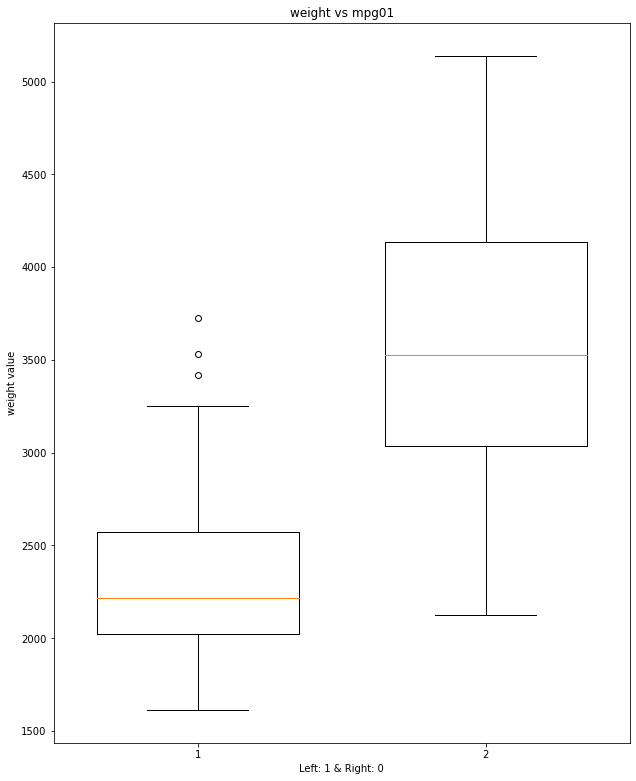

In [39]:
print_stats("weight")

#### Test and Compare all Features

The call to print_stats() in this cell was merely commented out to keep the function from flooding the PDF, can be uncommented and should work perfectly fine, as it makes use of the same function as the individual model above.

In [40]:
# removing the bad columns
all_columns = list(auto_data.columns)
all_columns.remove("id")
all_columns.remove("mpg01")
all_columns.remove("mpg")

# for column in all_columns:
#     print_stats(column)


## Choose Feature, Feature Normalisation, Splitting Data => Training & Test Sets 

#### Choose our features based on analysis of each column above

In [41]:
# Note that the only column truly worth dropping here is the original MPG column, as it was converted into the classifier
features = auto_data[["cylinders", "displacement", "horsepower", "weight", "acceleration", "model", "origin"]]

#### We also need to scale / normalise or features => as not all features are equally significant

In [42]:
scaler = StandardScaler()
x = scaler.fit_transform(features)

#### Setting the class labels

In [43]:
y = np.array(auto_data["mpg01"])

#### Finally Splitting the data and labels into Training & Testing Sets: 80% => Training; 20% => Testing

Scikit-Learn has a neat function with which to split data into training and test sets. Observe below, the train_test_split() function takes 2 specific parameters named 'train_size' and 'test_size', the former is set to 0.8 and the latter to 0.2. To explain this in brief terms, what this means is that a random 80% of the preprocessed dataset will be set aside to train the classification model, whereas the remaining 20% will be set aside for testing the model. One of the main keywords here is 'random'. Since the trainin data and test data will be split at random, this eliminates the element of bias that can be introduced if selected by hand. 

In [44]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, test_size = 0.2)

# x_train & y_train will be used to fit/train the model
# x_test & y_test will be used to test/validdte the trained odel

#### Just print everything to check

In [45]:
# print(x_train)
# print(y_train)
# print(x_test)
# print(y_test)

# Step Further: Logistic Regression with the Data

In [46]:
logger = LogisticRegression()
logger.fit(x_train, y_train)

LogisticRegression()

In [47]:
# to find the Most Important feature => feature with the highest coefficient
# print(feature_coefficients)

# coefficient and intercept for the regression model
feature_coefficients = logger.coef_
intercept = logger.intercept_

features_to_coefficients = list(zip(features, feature_coefficients[0]))
for item in features_to_coefficients:
    print(item)


# From here we can see that weight has the highest coefficient => most important feature in predicting Miles per Gallon

('cylinders', -0.5988175916294037)
('displacement', -0.8209498405395483)
('horsepower', -1.3350655905469693)
('weight', -1.9977303555997623)
('acceleration', -0.4058724012352035)
('model', 1.25207975175938)
('origin', 0.2887978157522764)


# Evaluate & Score Model

#### Make a prediction using the test data

In [48]:
y_pred = logger.predict(x_test)

#### Evaluate: Compare predictions and true labels off the eye

In [49]:
print("Predicted y:")
print(y_pred)
print("Test y:")
print(y_test)

Predicted y:
[1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 1 1 0 1 1 0 0 1 0 1
 0 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 1
 1 1 0 1 0 1]
Test y:
[1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1
 0 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 1
 1 1 0 1 0 1]


#### Print out a Score Sheet to evaluate the LR Model and the Data

In [50]:
print("Score Sheet:")
print(f"Score Model on Data: {round(logger.score(x_train, y_train), 2)}")
print(f"Accuracy Score: {round(accuracy_score(y_test, y_pred), 2)}")
print(f"Precision Score: {round(precision_score(y_test, y_pred), 2)}")
print(f"Recall Score: {round(recall_score(y_test, y_pred), 2)}")
print(f"F1 Score: {round(f1_score(y_test, y_pred), 2)}")

Score Sheet:
Score Model on Data: 0.89
Accuracy Score: 0.94
Precision Score: 0.92
Recall Score: 0.95
F1 Score: 0.94


# END